##Description:

    Investigate OTU abundances



# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/ordination/general/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [2]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [3]:
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)

foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Setting files

In [6]:
!cd $workDir; ln -f -s $biomFileDir$biomFile
!cd $workDir; ln -f -s $biomFileDir'../'$metadataFile
!cd $workDir; ls -thlc

total 432K
lrwxrwxrwx 1 bryan bryan  130 Jul 23 07:03 metadata_RhizCG_merged.txt -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/..//home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt
lrwxrwxrwx 1 bryan bryan  143 Jul 23 07:03 otu_table_wtax.biom -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning//home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom
-rw-rw-r-- 1 bryan bryan 424K Jul 22 19:52 sample_abundance.pdf


# Loading/editting OTU table

In [7]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)



##apply gsub across columns replacing __ w/ "" reload tax_table to phyloseq object

##Filter and transform samples
Transform to relative abundance and
remove taxa not seen more than 3 times in at least 5% of the samples 

In [ ]:
###Use sparsity filter

##Taxa distribution

###Controls 

In [8]:
%%R
Controls = subset_samples(physeq, is.na(DAP))
Controls = prune_taxa(taxa_sums(Controls) > 0, Controls)
print(Controls)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 227 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 227 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 227 tips and 226 internal nodes ]


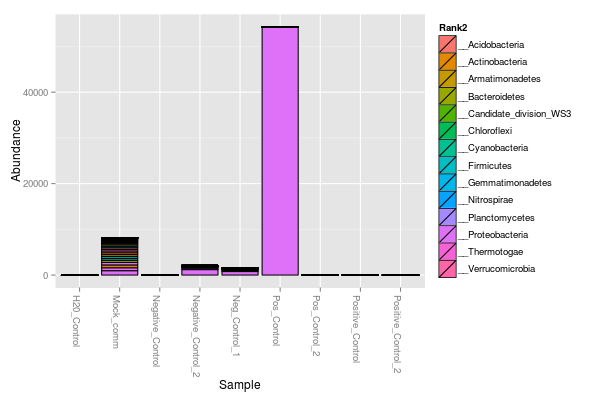

In [9]:
%%R -w 600 -h 400
plot_bar(Controls, fill = 'Rank2', x = "Sample")

In [30]:
%%R
Mock = subset_samples(physeq, X.sample == "Mock_comm")
Mock = prune_taxa(taxa_sums(Mock) > 0, Mock)

Pos = subset_samples(physeq, X.sample == "Pos_Control")
Pos = prune_taxa(taxa_sums(Pos) > 0, Pos)
tax_table(Pos)
unique(tax_table(Mock))

Taxonomy Table:     [36 taxa by 8 taxonomic ranks]:
          Rank1      Rank2               Rank3                    
OTU.409   "Bacteria" "__Acidobacteria"   "__Holophagae"           
OTU.1116  "Bacteria" "__Verrucomicrobia" "__Verrucomicrobiae"     
OTU.2936  "Bacteria" "__Acidobacteria"   "__Acidobacteriales"     
OTU.2132  "Bacteria" "__Bacteroidetes"   "__Sphingobacteriia"     
OTU.4013  "Bacteria" "__Bacteroidetes"   "__Flavobacteria"        
OTU.653   "Bacteria" "__Bacteroidetes"   "__Flavobacteria"        
OTU.6162  "Bacteria" "__Acidobacteria"   "__DA023"                
OTU.5957  "Bacteria" "__Firmicutes"      "__Bacilli"              
OTU.8456  "Bacteria" "__Firmicutes"      "__Bacilli"              
OTU.7459  "Bacteria" "__Firmicutes"      "__Bacilli"              
OTU.4596  "Bacteria" "__Firmicutes"      "__Bacilli"              
OTU.121   "Bacteria" "__Firmicutes"      "__Bacilli"              
OTU.8113  "Bacteria" "__Firmicutes"      "__Bacilli"              
OTU.8342  

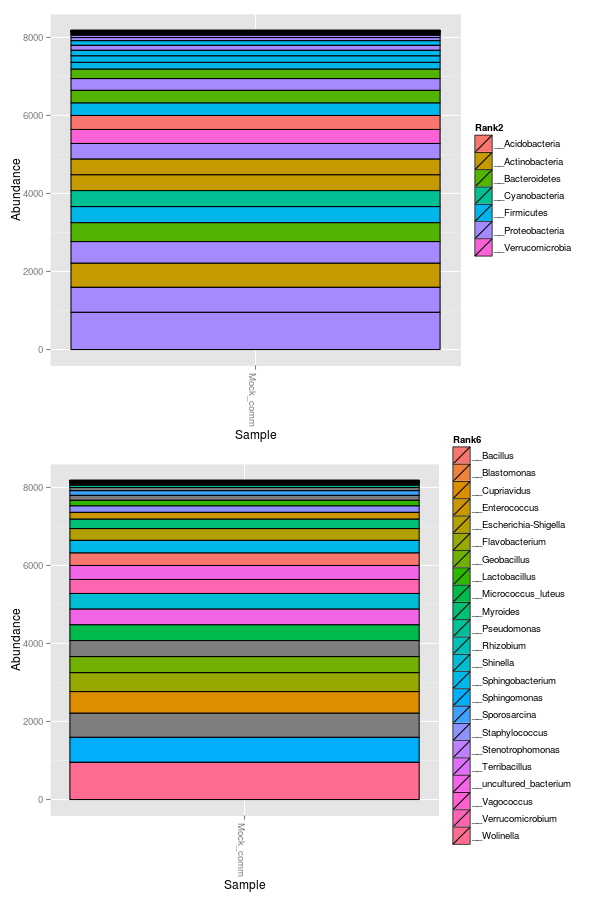

In [11]:
%%R -w 600 -h 900
p1 = plot_bar(Mock, fill = 'Rank2', x = "Sample")

p2 = plot_bar(Mock, fill = 'Rank6', x = "Sample")

grid.arrange(p1, p2, ncol=1)

#Rank Abundance

In [12]:
%%R
print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 249 samples ]
sample_data() Sample Data:       [ 249 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


In [13]:
%%R 
# filtering/normalizing
physeq.R = subset_samples(physeq, !is.na(DAP))
sample_data(physeq.R)
#physeq.trim = prune_samples(sample_sums(physeq.R) >= 10, physeq.R)
phy = transform_sample_counts(physeq.R, function(OTU) OTU/sum(OTU))
    
#print(phy)

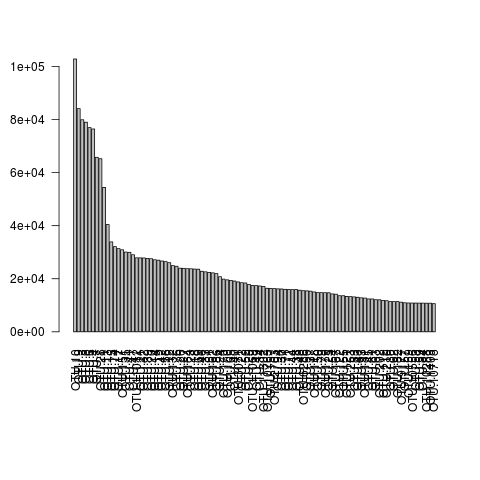

In [26]:
%%R
par(mar = c(10, 4, 4, 2) + 0.1) # make more room on bottom margin
N <- 100
barplot(sort(taxa_sums(physeq.R), TRUE)[1:N], las=2)

In [14]:
%%R
topNOTUs = names(sort(taxa_sums(physeq.R), TRUE)[1:20])
Rhiz20 = prune_taxa(topNOTUs, physeq.R)
print(Rhiz20)
sample_variables(Rhiz20)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 20 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 20 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 20 tips and 19 internal nodes ]
 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        


##Generate abundance bar plots for each sample

In [15]:
%%R -i workDir

#setwd(workDir)

#pdf("sample_abundance.pdf", onefile = TRUE)

#N = nsamples(physeq.R)

#for(i in 1:N){
#    samplename = sample_names(physeq.R)[i]
#    samplename
#    sample = subset_samples(physeq.R, X.sample == samplename)
  

#    TopOTUs = names(sort(taxa_sums(sample), TRUE)[1:20])
#    Top20 = prune_taxa(TopOTUs, sample)
#    title = paste(sample_data(sample)$Plant, samplename, sample_sums(sample), sep = " ")
#    plot = plot_bar(Top20, "Rank4", fill = "Rank5", title = title)
#    print(plot) 
#}

#dev.off()


NULL


##Graph abundance by phylum

In [16]:
%%R
colnames(tax_table(physeq.R)) = c("Kingdom", "Phylum",  "Class",   "Order",   
                         "Family",  "Genus",   "Species", "Strain")

In [17]:
%%R
get_taxa_unique(physeq.R, "Phylum")

 [1] "__Acidobacteria"           "__Planctomycetes"         
 [3] "__Proteobacteria"          "__Candidate_division_WS3" 
 [5] "__NPL-UPA2"                "__Nitrospirae"            
 [7] "__Spirochaetes"            "__Verrucomicrobia"        
 [9] NA                          "__Lentisphaerae"          
[11] "__Chloroflexi"             "__Fibrobacteres"          
[13] "__Candidate_division_BRC1" "__Fusobacteria"           
[15] "__Firmicutes"              "__Deferribacteres"        
[17] "__Chlorobi"                "__Bacteroidetes"          
[19] "__GOUTA4"                  "__Elusimicrobia"          
[21] "__JL-ETNP-Z39"             "__Gemmatimonadetes"       
[23] "__Tenericutes"             "__Deinococcus-Thermus"    
[25] "__Armatimonadetes"         "__Cyanobacteria"          
[27] "__TA06"                    "__Thermotogae"            
[29] "__Actinobacteria"          "__BHI80-139"              
[31] "__WCHB1-60"                "__Candidate_division_TM7" 
[33] "__Candidate_divisi

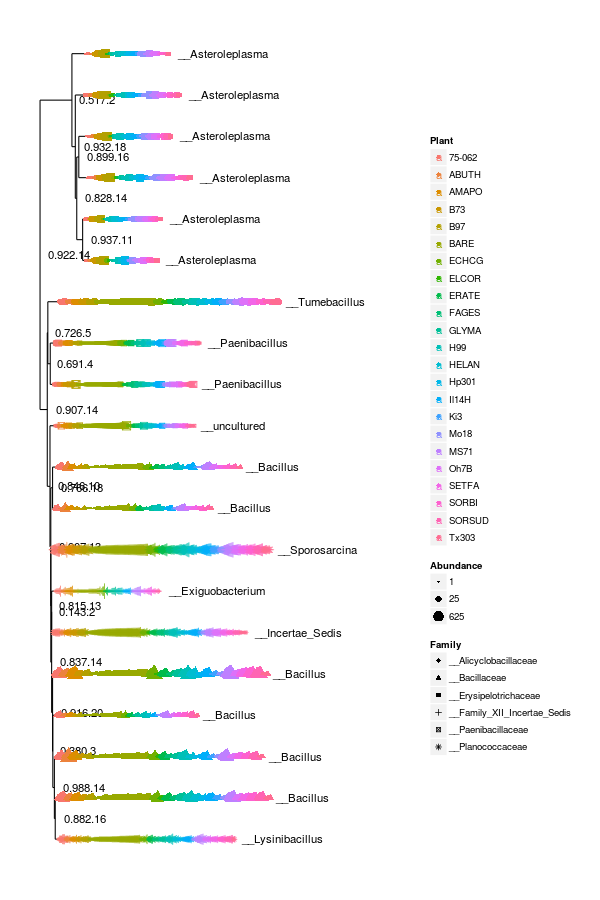

In [18]:
%%R -w 600 -h 900
Rhiz.f = subset_taxa(physeq.R, Phylum == "__Firmicutes")
topNOTUs = names(sort(taxa_sums(Rhiz.f), TRUE)[1:20])
Rhiz.ft = prune_taxa(topNOTUs, Rhiz.f)
plot_tree(Rhiz.ft, color = "Plant", shape = "Family", label.tips = "Genus", 
          size = "abundance", plot.margin = 0.5, ladderize = TRUE)

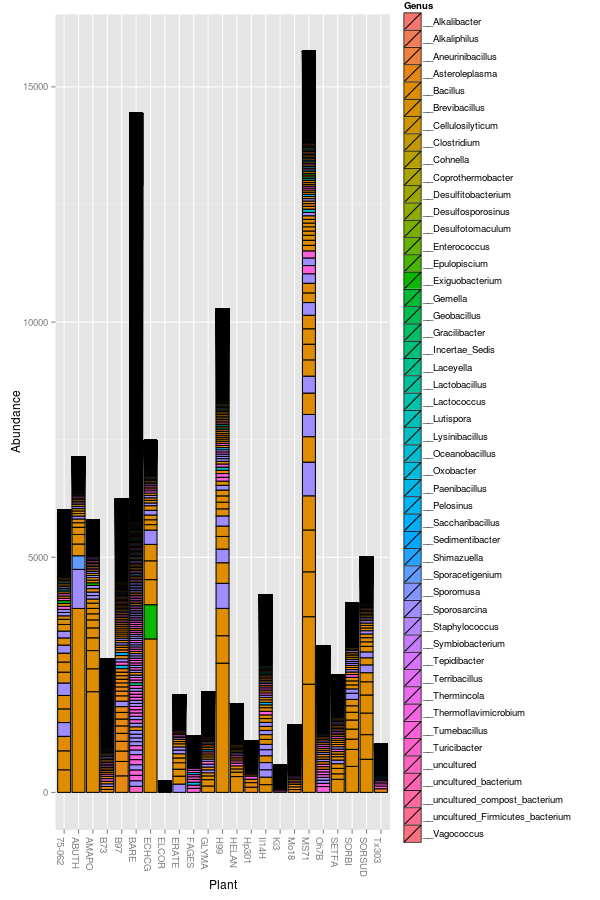

In [19]:
%%R -w 600 -h 900
p1 = plot_bar(Rhiz.f, x="Plant", fill="Genus")
p1

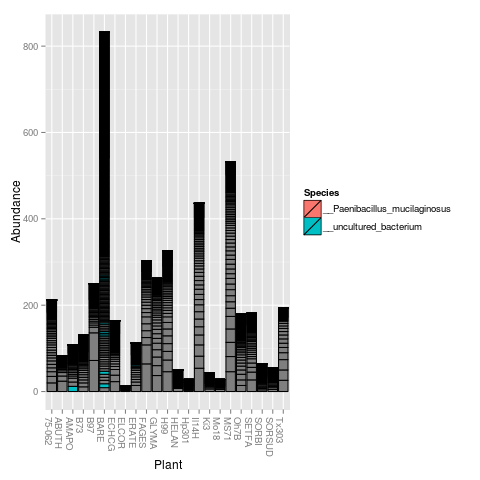

In [20]:
%%R
Rhiz.p = subset_taxa(physeq.R, Genus == "__Paenibacillus")
plot_bar(Rhiz.p, x="Plant", fill="Species")


In [22]:
%%R
head(otu_table(Rhiz.p))


OTU Table:          [6 taxa and 240 samples]
                     taxa are rows
          sample2-1.06_Npos sample6-4.27_Npos sample4-4.27_Nneg
OTU.6805                  0                 1                 0
OTU.4250                  0                 0                 0
OTU.1137                  3                 9                 4
OTU.9974                  0                 0                 0
OTU.10507                 1                 0                 0
OTU.12474                 0                 0                 0
          sample4-1.06_Nneg sample2-1.06_Nneg sample6-3.07_Nneg
OTU.6805                  2                 0                 0
OTU.4250                  0                 0                 0
OTU.1137                  0                 4                 1
OTU.9974                  0                 0                 0
OTU.10507                 0                 0                 0
OTU.12474                 0                 0                 0
          sample5-3.07_N